# Deep Learning Exercise 2
## MNIST prediction with mlp

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as clr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim

from sklearn.model_selection import train_test_split

### Import data

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


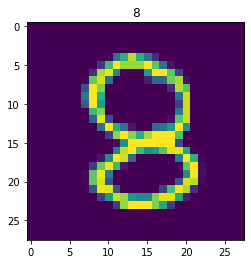

In [ ]:
with np.load('drive/My Drive/Deep Learning/prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER
# 2. INDEX: COLOR CHANNEL
# 3/4. INDEX: PIXEL VALUE
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)


plt.imshow(data_x[0, 0])
plt.title(data_y[0])
plt.show()

### Split training data into training and validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.1)

### Transform data into torch tensors

In [ ]:
BATCH_SIZE = 20

torch_X_train = torch.from_numpy(X_train)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_val = torch.from_numpy(X_val)
torch_y_val = torch.from_numpy(y_val).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
validate = torch.utils.data.TensorDataset(torch_X_val,torch_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(validate, batch_size = BATCH_SIZE, shuffle = False)

### Define neural network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# New Section

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 320)
        self.fc2 = nn.Linear(320, 160)
        self.fc3 = nn.Linear(160, 80)
        self.fc4 = nn.Linear(80, 40)
        self.fc5 = nn.Linear(40, 20)
        self.fc6 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1) 

net = Net()
print(net)  

Net(
  (fc1): Linear(in_features=784, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=160, bias=True)
  (fc3): Linear(in_features=160, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=40, bias=True)
  (fc5): Linear(in_features=40, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=10, bias=True)
)


### Define loss function and optimizer

In [ ]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Training and cross validation

In [ ]:
net.train() # prep model for training

train_loss = []
val_loss = []

for epoch in range(10):
    for data in train_loader:  
        X, y = data  
        net.zero_grad()  
        output = net(X.view(-1,784))  
        loss = loss_criterion(output, y)  
        loss.backward()  
        optimizer.step()  
    train_loss.append(loss.detach().numpy())
    val_loss.append(loss_criterion(net(torch_X_val.view(-1,784)),torch_y_val).detach().numpy())
    print('epoch %d:\ttraining loss: %.5f\tvalidation loss: %.5f'%(epoch,train_loss[-1],val_loss[-1])) 
    if val_loss[-1] < 0.25:
        break

epoch 0:	training loss: 0.02486	validation loss: 0.19083


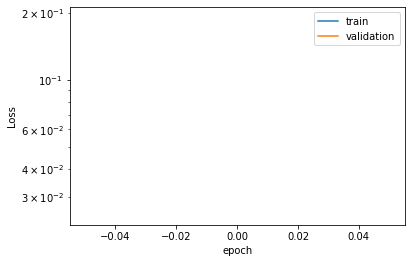

In [ ]:
f, ax = plt.subplots()
ax.semilogy(train_loss, label='train')
ax.plot(val_loss, label='validation')
ax.legend(loc='best')
ax.set_ylabel('Loss')
ax.set_xlabel('epoch');

In [ ]:
net.eval()

output_train = net(torch_X_train.view(-1,784)).detach().numpy().argmax(axis=1)
output_val = net(torch_X_val.view(-1,784)).detach().numpy().argmax(axis=1)

print('Training accuracy:\t%.3f'%(sum(output_train == y_train)/len(y_train)))
print('Validation accuracy:\t%.3f'%(sum(output_val == y_val)/len(y_val)))

Training accuracy:	0.953
Validation accuracy:	0.946


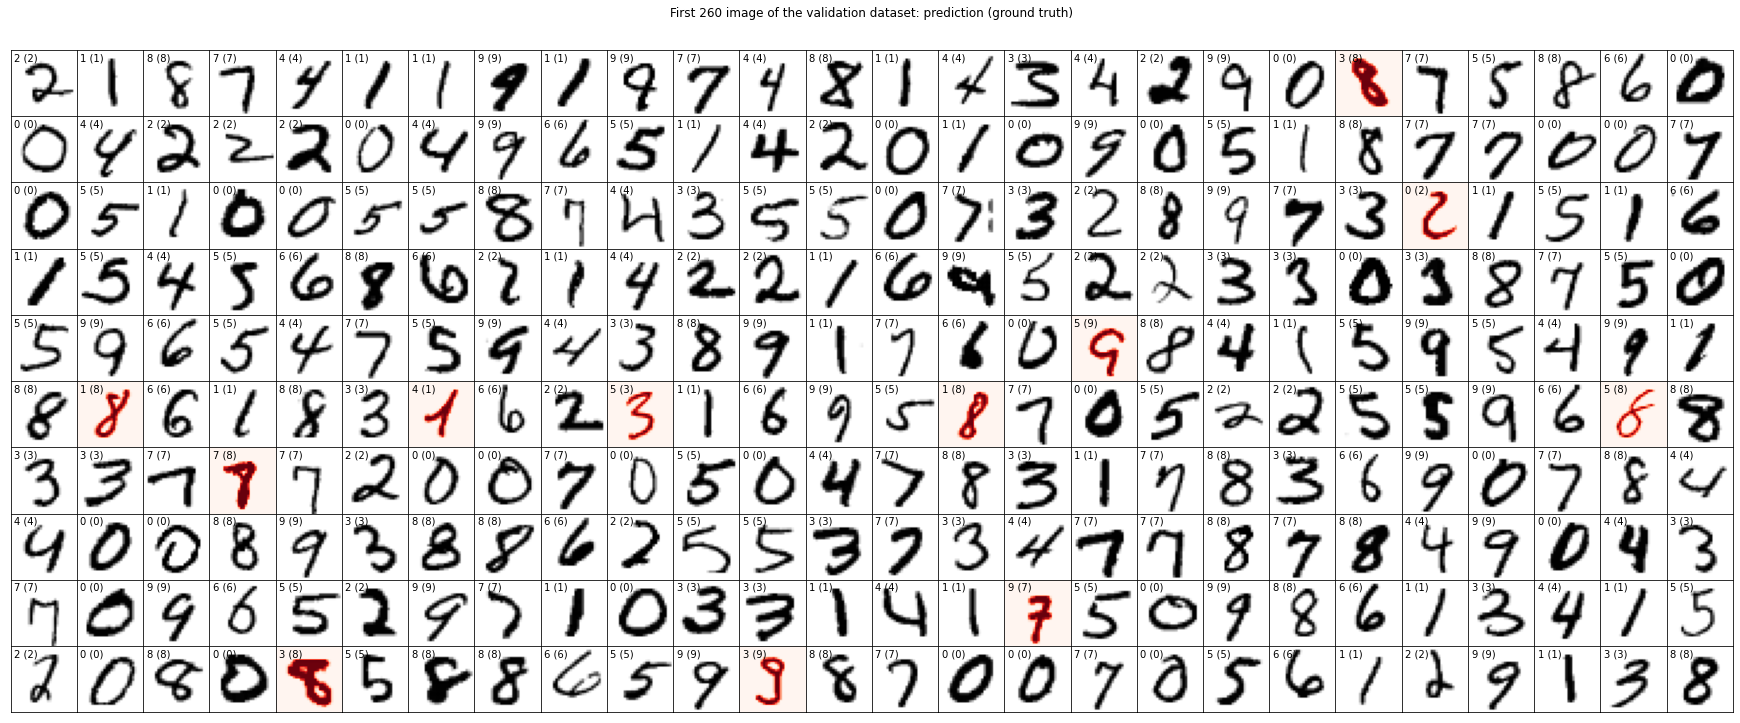

In [ ]:
f, ax = plt.subplots(10,26,figsize=(26,10))
plt.subplots_adjust(left=0.04, bottom=0, right=0.96, top=0.92, wspace=0.0, hspace=0.0)

for i in range(10):
    for j in range(26):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

        index = j + 26*i

        X = X_val[index,0,:,:]
        y_pred = net(torch.from_numpy(X).view(-1,784)).detach().numpy().argmax()

        cmap = cm.binary if y_val[index] == y_pred else cm.Reds
        ax[i,j].imshow(X,cmap=cmap)
        ax[i,j].annotate('%d (%d)'%(y_pred,y_val[index]), xy=(1,4))

plt.suptitle('First 260 image of the validation dataset: prediction (ground truth)');

In [ ]:
prediction = net(torch.from_numpy(test_x).view(-1,784)).cpu().detach().numpy().argmax(axis=1)

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 2000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('drive/My Drive/Deep Learning/prediction2.npy', final_prediction)

## MNIST with convolutional neural network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #1 is the depth of the input and the desired depth of the output is 16
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
net.train() # prep model for training

train_loss = []
val_loss = []

for epoch in range(10):
    for data in train_loader:  
        X, y = data  
        net.zero_grad()  
        output = net(X)  
        loss = loss_criterion(output, y)  
        loss.backward()  
        optimizer.step()  
    train_loss.append(loss.detach().numpy())
    val_loss.append(loss_criterion(net(torch_X_val),torch_y_val).detach().numpy())
    print('epoch %d:\ttraining loss: %.5f\tvalidation loss: %.5f'%(epoch,train_loss[-1],val_loss[-1])) 
    if val_loss[-1] < 0.2:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0:	training loss: 0.66246	validation loss: 0.62918
epoch 1:	training loss: 0.45481	validation loss: 0.42482
epoch 2:	training loss: 0.34806	validation loss: 0.33083
epoch 3:	training loss: 0.16811	validation loss: 0.38493
epoch 4:	training loss: 0.42342	validation loss: 0.33148
epoch 5:	training loss: 0.16416	validation loss: 0.26735
epoch 6:	training loss: 0.34199	validation loss: 0.26821
epoch 7:	training loss: 0.12514	validation loss: 0.25618
epoch 8:	training loss: 0.06817	validation loss: 0.26427
epoch 9:	training loss: 0.21837	validation loss: 0.27050


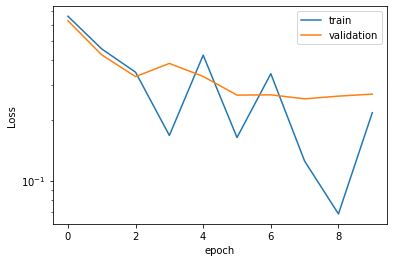

In [ ]:
f, ax = plt.subplots()
ax.semilogy(train_loss, label='train')
ax.plot(val_loss, label='validation')
ax.legend(loc='best')
ax.set_ylabel('Loss')
ax.set_xlabel('epoch');

In [ ]:
net.eval()

output_train = net(torch_X_train).detach().numpy().argmax(axis=1)
output_val = net(torch_X_val).detach().numpy().argmax(axis=1)

print('Training accuracy:\t%.3f'%(sum(output_train == y_train)/len(y_train)))
print('Validation accuracy:\t%.3f'%(sum(output_val == y_val)/len(y_val)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training accuracy:	0.984
Validation accuracy:	0.980


In [ ]:
prediction = net(torch.from_numpy(test_x)).cpu().detach().numpy().argmax(axis=1)

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 2000

# AND SAVE EXACTLY AS SHOWN BELOW
#np.save('prediction.npy', final_prediction)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## MNIST with Spatial transformer network

In [ ]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_val = torch.from_numpy(X_val)
torch_y_val = torch.from_numpy(y_val).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
validate = torch.utils.data.TensorDataset(torch_X_val,torch_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(validate, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)


In [ ]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [ ]:
net.train() # prep model for training

train_loss = []
val_loss = []
val_acc = []

for epoch in range(10):
    for data in train_loader:  
        X, y = data  
        net.zero_grad()  
        output = net(X)  
        loss = loss_criterion(output, y)  
        loss.backward()  
        optimizer.step()  
    train_loss.append(loss.detach().numpy())
    val_loss.append(loss_criterion(net(torch_X_val),torch_y_val).detach().numpy())
    output_val = net(torch_X_val).detach().numpy().argmax(axis=1)
    val_acc.append(sum(output_val == y_val)/len(y_val))
    print('epoch %d:\ttraining loss: %.5f\tvalidation loss: %.5f\tvalidation accuracy: %.5f'%(epoch,train_loss[-1],val_loss[-1],val_acc[-1])) 
    if val_acc[-1] > 0.99:
        break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


epoch 0:	training loss: 2.29850	validation loss: 2.30365	validation accuracy: 0.10700
epoch 1:	training loss: 2.30033	validation loss: 2.30296	validation accuracy: 0.11200
epoch 2:	training loss: 2.30103	validation loss: 2.30308	validation accuracy: 0.09750
epoch 3:	training loss: 2.30478	validation loss: 2.30347	validation accuracy: 0.10150
epoch 4:	training loss: 2.30569	validation loss: 2.30366	validation accuracy: 0.09650
epoch 5:	training loss: 2.30057	validation loss: 2.30303	validation accuracy: 0.09650
epoch 6:	training loss: 2.30459	validation loss: 2.30368	validation accuracy: 0.08750
epoch 7:	training loss: 2.30343	validation loss: 2.30392	validation accuracy: 0.09600
epoch 8:	training loss: 2.30648	validation loss: 2.30340	validation accuracy: 0.09650
epoch 9:	training loss: 2.30271	validation loss: 2.30339	validation accuracy: 0.09900
